# Data exploration

## Cancellations
We can see different how many cancellations there are per:  
    - stockcode: how many cancellations per stockcode and how many items of this stockcode where cancelled. 
    - customer: how many cancellations the customer has
    - per country: how many cancellations each country has 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from matplotlib import cm
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import countries as countries_utils 

In [2]:
df = pd.read_csv("cleaned_data.csv", encoding="ISO-8859-1")
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,0


In [3]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'cancelled'],
      dtype='object')

<AxesSubplot:>

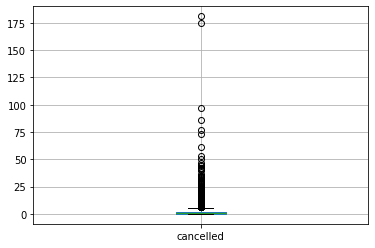

In [4]:
# amount of cancellations per stock
per_stockcode = df[['StockCode','cancelled','Quantity']].groupby(['StockCode']).sum().reset_index()
per_stockcode.boxplot(column=['cancelled'])

<AxesSubplot:>

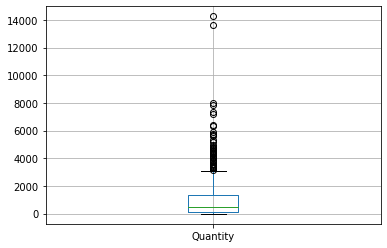

In [5]:
# amount of items of each stockcode where cancelled 
cancelled_per_stockcode = per_stockcode[per_stockcode['cancelled']==1]
cancelled_per_stockcode.boxplot(column=['Quantity'])

## Analyze outliers

From the graphs we can see that there are two products are cancelled more times. 

In [6]:
#print outliers
per_stockcode[per_stockcode['cancelled']>170]

,StockCode,cancelled,Quantity
1292,22423,181,11555
3681,M,175,3184


<AxesSubplot:>

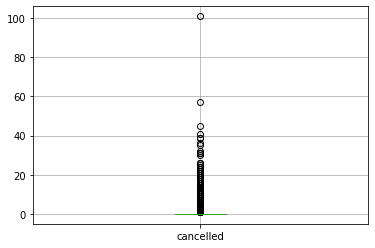

In [7]:
# cancellations per customer. 
per_client = df[['CustomerID','InvoiceNo','cancelled']].groupby(['CustomerID','InvoiceNo']).sum().reset_index()
per_client.boxplot(column=['cancelled'])

From the graph, we can see that there is an outlier, a customer that cancelled more than 100 orders.  

In [8]:
#print outlier 
per_client[per_client['cancelled']>100]

,CustomerID,InvoiceNo,cancelled
1004,12607.0,C570867,101


<AxesSubplot:>

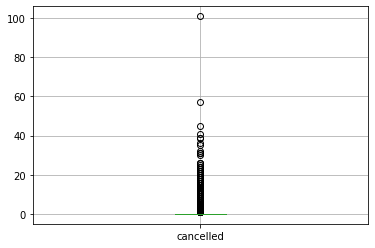

In [9]:
# cancellations per customer. 
per_country = df[['Country','InvoiceNo','cancelled']].groupby(['Country','InvoiceNo']).sum().reset_index()
per_country.boxplot(column=['cancelled'])

There is a country that is outlier, we can check which is that country by filtering the data.

In [10]:
#print outlier 
per_country[per_country['cancelled']>100]

,Country,InvoiceNo,cancelled
2320,USA,C570867,101


## Data Fusion

We can see the cancellations among countries. In order to do this, we can merge with a dataset that contains the location for each country, and in this way create a world map to visualize it.

Check which countries are not common for both datasets.

In [11]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = per_country[['Country','cancelled']].groupby(['Country']).sum().reset_index()
world_values = world['name'].values
countries['is_in'] = np.array([x in world_values for x in countries['Country']])
print(countries[countries['is_in']==False])

               Country  cancelled  is_in
2              Bahrain          0  False
6      Channel Islands         10  False
8       Czech Republic          5  False
10                EIRE        247  False
11  European Community          1  False
22               Malta         15  False
27                 RSA          0  False
29           Singapore          7  False
33                 USA        112  False
36         Unspecified          0  False


Rename countries to match with world dataset

In [12]:
countries_utils.update_values(countries, 'Country', ['USA', 'RSA', 'Czech Republic', 'EIRE'],
                             ['United States of America', 'South Africa', 'Czechia', 'Ireland'])


Keep only countries that can be plotted with the world dataset

In [13]:
countries['is_in'] = np.array([x in world_values for x in countries['Country']])
countries = countries[countries['is_in']].copy() 
countries.drop(columns=['is_in'], axis=1, inplace=True)
countries

,Country,cancelled
0,Australia,74
1,Austria,3
3,Belgium,38
4,Brazil,0
5,Canada,0
7,Cyprus,8
8,Czechia,5
9,Denmark,9
10,Ireland,247
12,Finland,10


## Data Visualization

Finally, we can plot the cancellations per country into the map. 
We know that United Kingdom is an outlier, so we can plot the graph with and without the outlier to see how the cancellations are distributed among countries. 

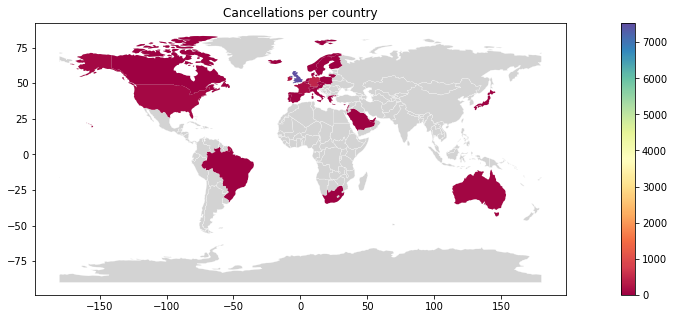

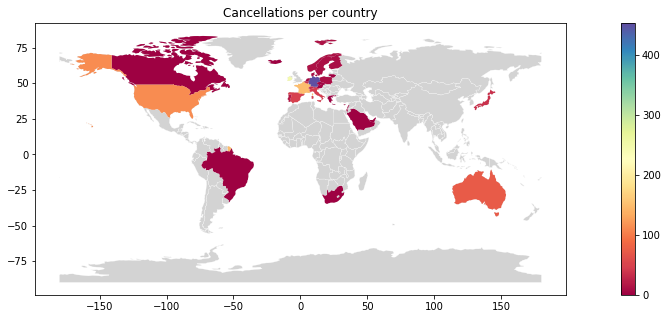

In [14]:
countries_utils.plot(countries, 'Cancellations per country', 'Country', 'cancelled', True)

#without United Kingdom since it has a lot of cancellations and it might be the outlier that we saw in the other graph
countries_utils.plot(countries[countries['Country'] != 'United Kingdom'], 'Cancellations per country', 'Country', 'cancelled', True)

## Sales

Now, we can visualize the amount of invoices per country. In this case we are also removing United Kingdom since it has a lot of sales 


/Users/rootstrap/Projects/datasciene-ecommerce/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Greece'),
  Text(22, 0, 'Singapore'),
  Text(23, 0, 'Lebanon'),
  Text(24, 0, 'United Arab Emirates'),
  Text(25, 0, 'Israel'),
  Text(26, 0, 'Saudi Arabia'),
  Text(27, 0, 'Czech Republic'),
  Text(28, 0, 'Canada'),
  Text(29, 0, 'Unspecified'),
  Text(30, 0, 'Brazil'),


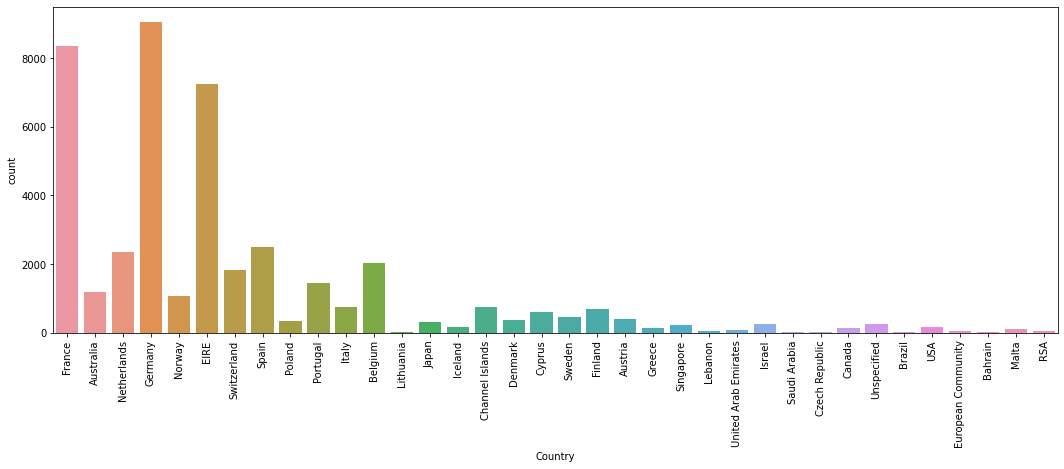

In [15]:
plt.figure(figsize=(18,6))
sns.countplot(df[(df['Country'] != 'United Kingdom') & (df['cancelled']==0)]['Country'])
plt.xticks(rotation=90)

## Products

For the products, we can show the top 10 products for each country (the most popular products). We use the quantity field, which indicates how many times the product was purchased in the whole purchase. So, we should have to group by country and product and make the sum. 

In [16]:
products = df[['StockCode', 'Country', 'Quantity','Description']].groupby(['StockCode', 'Country','Description']).sum().reset_index()


If we want to see the top 10 products for a specific country, the code would be

In [17]:
UK_products = products[products['Country']=='United Kingdom'].sort_values('Quantity', ascending=False).reset_index().head(10)
UK_products

,index,StockCode,Country,Description,Quantity
0,17114,84077,United Kingdom,WORLD WAR 2 GLIDERS ASSTD DESIGNS,47982
1,18552,85099B,United Kingdom,JUMBO BAG RED RETROSPOT,40880
2,17856,84879,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,32679
3,18618,85123A,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,32097
4,5765,22197,United Kingdom,POPCORN HOLDER,28562
5,8578,22616,United Kingdom,PACK OF 12 LONDON TISSUES,24313
6,310,17003,United Kingdom,BROCADE RING PURSE,22708
7,2001,21212,United Kingdom,PACK OF 72 RETROSPOT CAKE CASES,22205
8,5619,22178,United Kingdom,VICTORIAN GLASS HANGING T-LIGHT,21456
9,4551,21977,United Kingdom,PACK OF 60 PINK PAISLEY CAKE CASES,19916


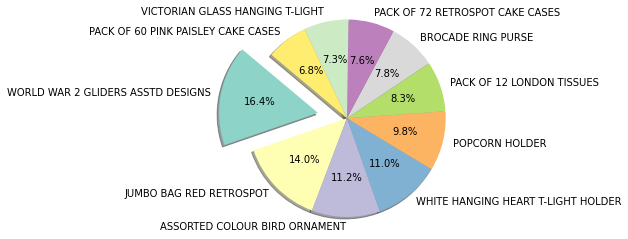

In [18]:
# Data to plot
labels = UK_products['Description']
sizes = UK_products['Quantity']

#separate maximum 
x = np.zeros(sizes.shape[0])
x[0] = 0.3
colors = cm.get_cmap('Set3', sizes.shape[0]).colors

# Plot
plt.pie(sizes, labels=labels, explode=x, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Now, we can define a function that return the top 10 products for each country.

In [19]:
def get_top_n(df, col, col_sort, n): 
    df_ret = pd.DataFrame()
    for i in df[col].unique():
        df_aux = df[df[col]==i].sort_values(col_sort, ascending=False).reset_index()
        df_aux = df_aux[0:n]
        df_ret = df_ret.append(df_aux)
    return df_ret

get_top_n(products, 'Country', 'StockCode', 10)

,index,StockCode,Country,Description,Quantity
0,19362,M,EIRE,Manual,-1
1,19355,D,EIRE,Discount,-1
2,19351,C2,EIRE,CARRIAGE,97
3,19315,90209C,EIRE,PINK ENAMEL+GLASS HAIR COMB,0
4,19312,90209A,EIRE,PURPLE ENAMEL+GLASS HAIR COMB,0
...,...,...,...,...,...
5,16067,37449,Bahrain,CERAMIC CAKE STAND + HANGING CAKES,2
6,16035,37446,Bahrain,MINI CAKE STAND WITH HANGING CAKES,8
7,12135,23077,Bahrain,DOUGHNUT LIP GLOSS,60
8,12121,23076,Bahrain,ICE CREAM SUNDAE LIP GLOSS,96


Plot top 10 products for the first 4 countries that have more sales

In [20]:
top_4 = df[['Country','Quantity']].groupby('Country').count().reset_index().sort_values('Quantity', ascending=False).head(4)

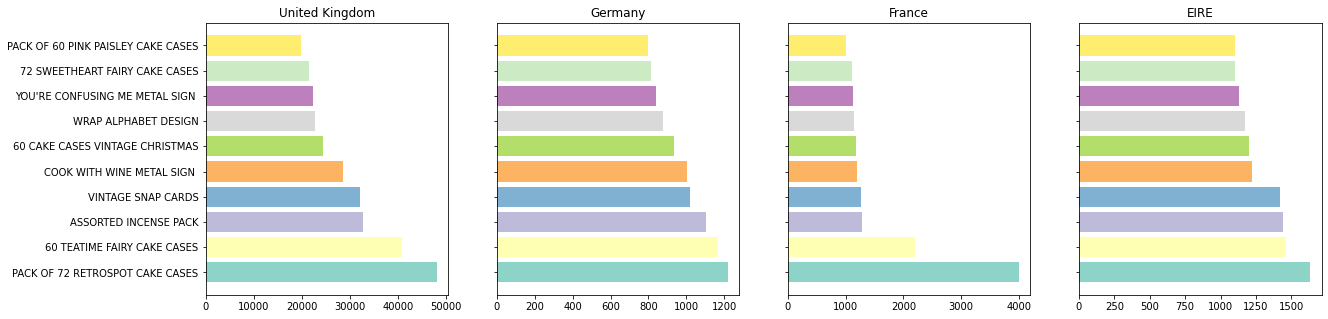

In [21]:
def plot_filter_bar(ax, df, filter_col, col_x, col_y, filter_value, n, title):
    filter_df = df[df[filter_col]==filter_value]
    colors = cm.get_cmap('Set3', n).colors
    ax.invert_yaxis()
    ax.barh(y=filter_df.index, width=col_x, data=filter_df, color=colors)
    ax.set_yticks(range(0,n))
    ax.set_yticklabels(filter_df[col_y].tolist())           
    ax.set_title(title)    
    return ax

f, axs = plt.subplots(1,4, figsize=(20,5), sharex=False, sharey=True)
i = 0
for country in top_4['Country']:
    axs[i] = plot_filter_bar(axs[i],get_top_n(products, 'Country', 'Quantity', 10), 
                             'Country', 'Quantity', 'Description', 
                country, 10, country)
    i+=1

plt.show()

See the most cancelled products for those countries

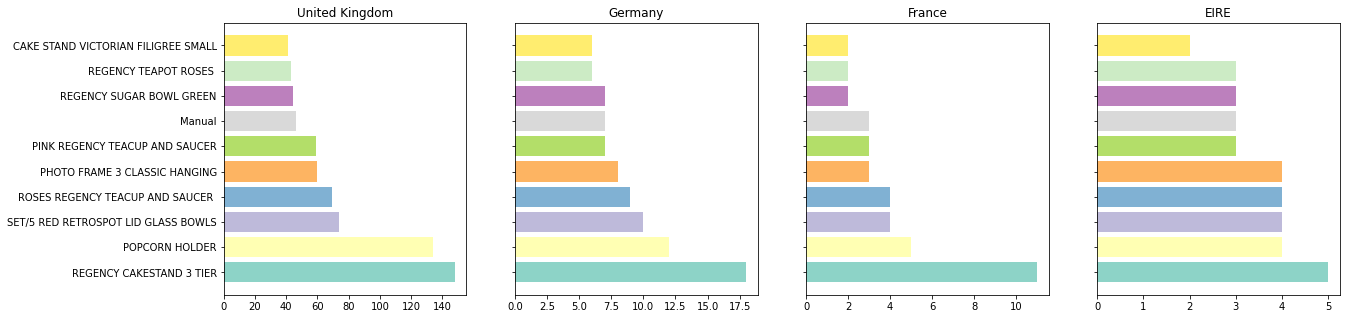

In [22]:
df['cancelled'] = df['InvoiceNo'].str.startswith('C').astype('int32')
cancelled_products = df[['Description', 'Country', 'cancelled']].groupby(['Description', 'Country']).sum().reset_index()
cancelled_products = get_top_n(cancelled_products, 'Country', 'cancelled', 10)

f, axs = plt.subplots(1,4, figsize=(20,5), sharex=False, sharey=True)
i = 0
for country in top_4['Country']:
    axs[i] = plot_filter_bar(axs[i],cancelled_products, 'Country', 'cancelled', 'Description', country, 10, country)
    i+=1

plt.show()